# Classifying Manhattan with BigQuery and TensorFlow

<br/>
![](images/manhattan.png)
<br/>
<br/>


## Clear all Cells

## Importing the training data from BigQuery

In [1]:
%%sql -d standard
SELECT
  timestamp,
  borough,
  latitude,
  longitude
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
ORDER BY
  timestamp DESC
LIMIT
  15

timestamp,borough,latitude,longitude
2017-07-29 23:55:00,,40.71376,-73.9793
2017-07-29 23:54:00,MANHATTAN,40.8032,-73.934616
2017-07-29 23:51:00,BROOKLYN,40.696198,-73.98869
2017-07-29 23:50:00,BROOKLYN,40.63129,-74.02704
2017-07-29 23:50:00,BROOKLYN,40.627632,-73.93652
2017-07-29 23:40:00,BROOKLYN,40.627632,-73.93652
2017-07-29 23:35:00,QUEENS,40.684742,-73.86081
2017-07-29 23:35:00,,40.801754,-73.93121
2017-07-29 23:30:00,BROOKLYN,40.66367,-73.91213
2017-07-29 23:30:00,BROOKLYN,40.65314,-73.978294


## Preprocess the training data on BigQuery

In [2]:
%%sql --module nyc_collisions
SELECT
  IF(borough = 'MANHATTAN', 1, 0) AS is_mt,
  latitude,
  longitude
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  LENGTH(borough) > 0
  AND latitude IS NOT NULL AND latitude != 0.0
  AND longitude IS NOT NULL AND longitude != 0.0
  AND borough != 'BRONX'
ORDER BY
  RAND()
LIMIT
  10000

## Import the BigQuery SQL result as NumPy array

In [3]:
import datalab.bigquery as bq
nyc_cols = bq.Query(nyc_collisions).to_dataframe(dialect='standard').as_matrix()

import numpy as np
is_mt = nyc_cols[:,0].astype(np.int32)
latlng = nyc_cols[:,1:3].astype(np.float32)
print("Is Manhattan: " + str(is_mt))
print("\nLat/Lng: \n\n" + str(latlng))
print("\nLoaded " + str(is_mt.size) + " rows.")

Is Manhattan: [0 1 0 ..., 0 0 0]

Lat/Lng: 

[[ 40.73859787 -73.87743378]
 [ 40.78768539 -73.97501373]
 [ 40.66792679 -73.86145782]
 ..., 
 [ 40.70357513 -73.76780701]
 [ 40.68089676 -73.87892914]
 [ 40.66407394 -73.8660965 ]]

Loaded 10000 rows.


## Feature scaling and plotting

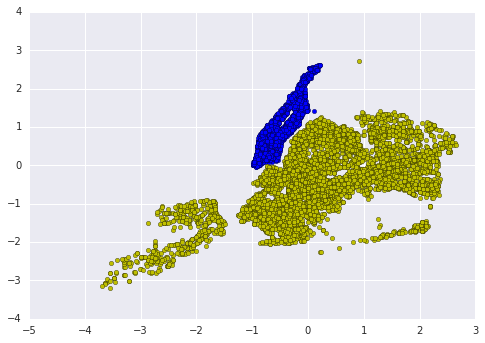

In [4]:
# standardization
from sklearn.preprocessing import StandardScaler
latlng_std = StandardScaler().fit_transform(latlng)

# plotting
import matplotlib.pyplot as plt
lat = latlng_std[:,0]
lng = latlng_std[:,1]
plt.scatter(lng[is_mt == 1], lat[is_mt == 1], c='b') # plot points in Manhattan in blue
plt.scatter(lng[is_mt == 0], lat[is_mt == 0], c='y') # plot points outside Manhattan in yellow
plt.show()

## Split the data into "Training Data" and "Test Data"

In [5]:
# 8,000 pairs for training
latlng_train = latlng_std[0:8000]
is_mt_train = is_mt[0:8000]

# 2,000 pairs for test
latlng_test = latlng_std[8000:10000]
is_mt_test = is_mt[8000:10000]

## Define a neural network

In [6]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR) # supress warning messages

# define two feature columns with real values
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=2)]

# create a neural network
dnnc = tf.contrib.learn.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[20, 20, 20, 20],
  n_classes=2)

dnnc

DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinaryLogisticHead object at 0x7fb8ccc65d50>, 'hidden_units': [20, 20, 20, 20], 'feature_columns': (_RealValuedColumn(column_name='', dimension=2, default_value=None, dtype=tf.float32, normalizer=None),), 'embedding_lr_multipliers': None, 'optimizer': None, 'dropout': None, 'gradient_clip_norm': None, 'activation_fn': <function relu at 0x7fb8d41b31b8>, 'input_layer_min_slice_size': None})

### Check the accuracy of the neural network

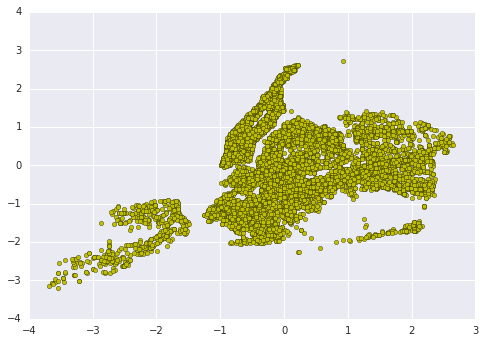

Accuracy: 70.70%


In [7]:
# plot a predicted map of Manhattan
def plot_predicted_map(classifier):
  is_mt_pred = classifier.predict(latlng_std, as_iterable=False) # an array of prediction results
  plt.scatter(lng[is_mt_pred == 1], lat[is_mt_pred == 1], c='b')
  plt.scatter(lng[is_mt_pred == 0], lat[is_mt_pred == 0], c='y')
  plt.show()

# print the accuracy of the neural network 
def print_accuracy(classifier):
  accuracy = classifier.evaluate(x=latlng_test, y=is_mt_test)["accuracy"]
  print('Accuracy: {:.2%}'.format(accuracy))
  
# train the model just for 1 step and print the accuracy
dnnc.fit(x=latlng_train, y=is_mt_train, steps=1)
plot_predicted_map(dnnc)
print_accuracy(dnnc)

### Train the neural network

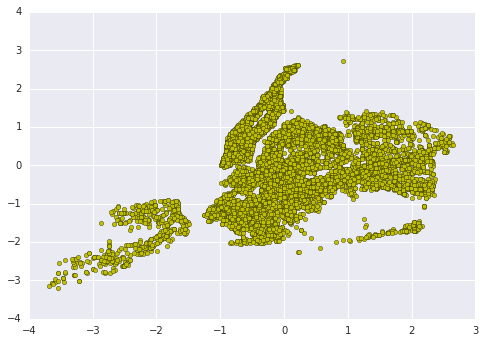

Steps: 20


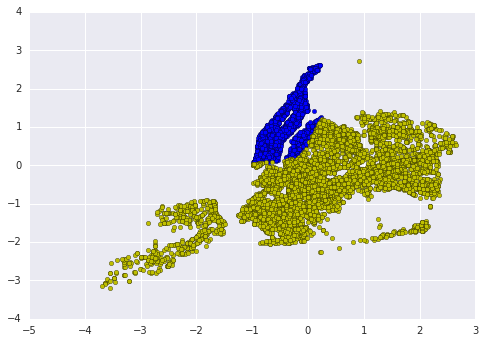

Steps: 40


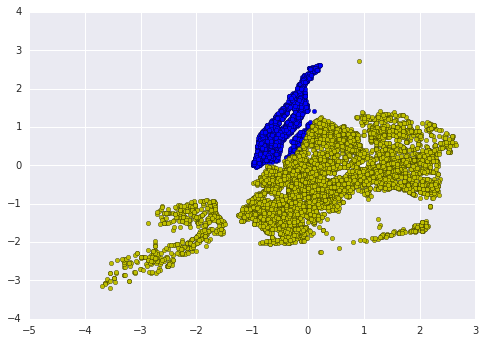

Steps: 60


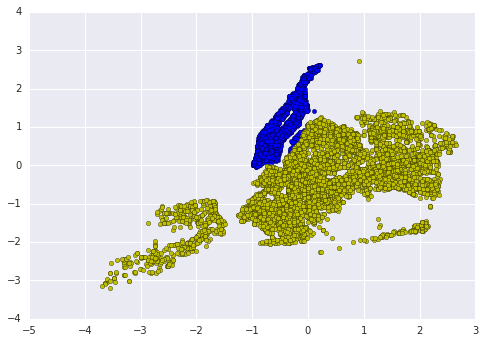

Steps: 80


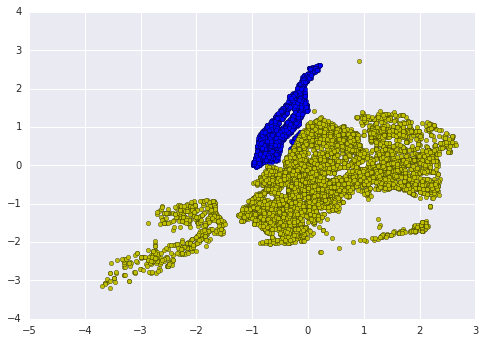

Steps: 100

Training Finished.
Accuracy: 99.75%


In [8]:
steps = 20
for i in range (1, 6):
  dnnc.fit(x=latlng_train, y=is_mt_train, steps=steps)
  plot_predicted_map(dnnc)
  print('Steps: ' + str(i * steps))
  
print('\nTraining Finished.')
print_accuracy(dnnc)